**VPG** (Vanilla Policy Gradient), is a direct implementation of the Policy Gradient Theorem using neural networks.

VPG uses a neural network to approximate the policy:
* The input to the network is the current state $s_t$.
* The outputs of the network are the parameters of the probability distributions that model the policy. Thus, if our policy is Gaussian, we need a mean and standard deviation; if categorical, we need the probability of each category...

Note that this means that **the state and the actions can be continuous and/or discrete**.

The algorithm works in two main phases:
* First, it builds a batch of data composed of states, actions, and rewards, by interacting with the environment. Remember that we directly use the policy to sample, hence, we may need to inject noise to enforce exploration (not in this implementation).
* Then, the policy network is updated using the Policy Gradient Theorem as:
$$
\nabla_{\phi}J(\pi_{\phi})=\mathbb{E}_{\tau\sim\pi_{\phi}}\Bigg[\sum_{t=0}^{T}\nabla_{\phi}\log\pi_{\phi}(a_{t}|s_{t})\cdot R(\tau)\Bigg]
$$
 where $J$ is the objective function, $\phi$ are the policy neural network parameters, $\tau$ is a trajectory, $\pi$ denotes the policy, $s$ is a state, $a$ is an action, and $R(\tau)$ is the cumulative reward of the trajectory.

An important difference to DQN is that we do not have a replay memory to store samples: each time that the policy is updated, a new batch of samples using the new policy is obtained by interacting with the environment.

Let's start with the code! First, as usual, we import the main libraries we are going to use for this extremely simple version of VPG, applied to the Cartpole problem. We need to install the Gymnasium library, which implements the Cartpole.

In [11]:
!pip install gymnasium
import torch
import torch.nn as nn
import numpy as np
import random
import gymnasium as gym
import matplotlib.pyplot as plt
%matplotlib inline

Next, we are going to create a simple MLP model to approximate the policy approximator. Note that the neural network is quite simple: depending on the problem to be addressed, it may suffice to use simple neural networks in DRL (and hence, it is possible to train using a CPU).

An important point to note is that the activation of the last layer is a Softmax. As mentioned in class, the reason for this is that we are going to model a problem with discrete actions, so we use a Categorical distribution, whose parameters are the probabilities for each class. Note that this means that:
* By using a Softmax, we are enforcing that the outputs of the MLP are the probabilities of each action.
* The log-likelihood of each action is simply the logarithm of the probability of each action.

If you wanted to use this code for a different policy (i.e., such as Gaussian), you will need to change both the MLP output and the log-likelihood computation in the Agent.

In [12]:
class MLP(nn.Module):
    def __init__(self, input_size, output_size, final_activation=nn.Softmax(dim=1), hidden_size=128):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size,output_size)
        self.relu = nn.ReLU()
        self.final_activation = final_activation

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        if self.final_activation is not None:
            x = self.final_activation(x)
        return x


Next, we are going to define the agent. The methods implemented are:
* The **init** method sets up all parameters and initializes the policy neural network.
* The **get_action** method samples one action from the policy. As the code assumes a Categorical distribution, we sample using such a distribution.
* The **train** method is the main method: it takes as input an environment, and proceeds to train the algorithm using the two phases mentioned before: it interacts with the environment to build a batch of data, and then updates the policy using the Policy Gradient Theorem. As mentioned in class, note that the *loss* is not an actual loss, as it is the gradient of the objective $J$ (although it is standard to call it loss).

In [13]:
class VPGAgent:  # VPG Agent
    def __init__(self, state_size, action_size, device=None):
        # Define state and action space sizes
        self.state_size = state_size
        self.action_size = action_size  # In this implementation, we use discrete actions
        # create the policy model and target model
        if device is None:
            self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # To use GPU if available
        else:
            self.device = device
        print('VPG is using device: ', self.device)
        self.model = MLP(self.state_size, self.action_size, hidden_size=64).to(self.device) # The main model is an MLP
        # Define the optimizer
        self.learning_rate = 0.01 # Learning rate for ADAM optimizer
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.learning_rate)

    # Epsilon greedy policy
    def get_action(self, state):
        state = np.reshape(state, [1, self.state_size])
        ac_prob = self.model(torch.from_numpy(state).to(self.device)).detach().cpu().numpy()
        return np.random.choice(self.action_size, p=ac_prob[0])

    # Function to train the agent
    def train(self, env, max_episodes=300, verbose=True, verbose_interval=10, batch_size=64):

        scores, episodes, losses = [], [], []  # To store values for plotting
        break_flag = False  # To stop training when the agent has successfully learned

        for e in range(max_episodes):
            self.model.eval()  # Set the model to evaluation mode

            states, actions, returns, episode_returns = [], [], [], []  # To store the samples of the batch

            state, _ = env.reset(seed=np.random.randint(1000))  # Set the initial state
            rews = []  # To store the rewards of the episode

            while True:
                states.append(state.copy())  # Save the state
                action = self.get_action(state)  # Get the action
                state, reward, terminated, truncated, info = env.step(action)  # Go one step in the environment
                done = terminated or truncated
                # Save info for the batch
                actions.append(action)
                rews.append(reward)

                if done:  # If the episode has finished
                    episode_returns.append(np.sum(rews))  # Save the episode return
                    returns += [sum(rews)] * len(rews)  # This is R(tau), the total undiscounted reward

                    #reset variables
                    state, _ = env.reset(seed=np.random.randint(1000))  # Set the initial state
                    done = False
                    rews = []

                    if len(states) >= batch_size:
                        break  # If we have enough samples, stop the episode. Note that batch_size is the minimum number of samples

            states = torch.from_numpy(np.vstack(states)).to(self.device)
            actions = torch.from_numpy(np.vstack(actions)).type(torch.LongTensor).to(self.device)
            returns = torch.from_numpy(np.vstack(returns)).to(self.device)

            # Now, train the agent
            self.model.train()  # Set the model to training mode
            self.optimizer.zero_grad()  # Reset the optimizer
            # Get the probabilities of the actions taken
            log_probs = torch.log(self.model(states))
            # Get the log probabilities of the actions taken
            log_probs_actions = torch.gather(log_probs, 1, actions)
            # Compute the loss
            loss = -torch.mean(log_probs_actions * returns)
            # Compute the gradients
            loss.backward()
            # Update the parameters of the model
            self.optimizer.step()

            # Save values for plotting
            if verbose and e % verbose_interval == 0:
                print("Episode: {}/{}, score: {}, loss: {}".format(e, max_episodes, np.mean(episode_returns), loss.item()))

            scores.append(np.mean(episode_returns))
            episodes.append(e)
            losses.append(loss.item())

            # Stop if mean scores of last 5 episodes is higher than 490
            if np.mean(scores[-min(5, len(scores)):]) > 490:
                break_flag = True
                break
        # Output whether the agent learnt or not
        if break_flag:
            print("Training finished successfully")
        else:
            print("Training finished unsuccessfully")

        return episodes, scores, losses

Let us now describe the environment where we are going to train our agent: the Cartpole problem. We have a moving cart with a pole and a mass on top, and want to keep the pole vertical.

* The state set is continuous and has 4 components: pole angle and angular speed, and cart position and velocity.

* The action set is $A=\left[LF,RF\right]$ and are the forces applied to the cart pole, where $LF$ is a left force and $RF$ is a right force.

* The rewards are $+1$ for every time step that the pole has not fallen: if the pole surpasses a certain angle (i.e., it falls), the episode terminates.

We use the Gymnasium library, which contains many environments implemented for DRL.

The CartPole environment allows up to 500 time steps. That is the maximum time of play. This time could be increased with env._max_episode_steps, but we use 500 for demonstration purposes.

In [14]:
env = gym.make('CartPole-v1')

A known problem of DRL are the reproducibility issues (see Henderson, P., Islam, R., Bachman, P., Pineau, J., Precup, D., & Meger, D. (2018, April). Deep reinforcement learning that matters. In Proceedings of the AAAI conference on artificial intelligence (Vol. 32, No. 1), https://doi.org/10.48550/arXiv.1709.06560).

To prevent that, the code is seeded: note that changing the seed will change the results, as DRL is known to be extremely sensitive to the initial conditions.

In [15]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

We are finally ready! Now, we can train our agent and see what they learn. In order to show the differences between seeds, we are going to run $3$ different initial seeds: note how they have very different convergence properties, in spite of the fact that all hyperparameters are the same, except for the seed! In VPG, this problem is specially acute, as the Policy Gradient estimator has a high variance: thus, Actor-Critic methods are more adequate in general than simple VPG.

Again, remember that the loss is not an actual loss! Thus, we must check the convergence using the score.

In [16]:
trials = 3
episodes, scores, losses = [], [], []

for i in range(trials):
    print("Trial {}/{}".format(i + 1, trials))
    # Create the agent
    agent = VPGAgent(env.observation_space.shape[0], env.action_space.n, device='cpu')
    # Train the agent
    e, s, l = agent.train(env, max_episodes=500, verbose=True, verbose_interval=10, batch_size=1024)
    episodes.append(e)
    scores.append(s)
    losses.append(l)

Trial 1/3
VPG is using device:  cpu
Episode: 0/500, score: 22.88888888888889, loss: 19.962463728490384
Episode: 10/500, score: 39.111111111111114, loss: 36.83048401899269
Episode: 20/500, score: 72.53333333333333, loss: 49.9953665679735
Episode: 30/500, score: 134.625, loss: 69.73275706349823
Episode: 40/500, score: 57.111111111111114, loss: 26.770972449908776
Episode: 50/500, score: 92.08333333333333, loss: 46.317799299014034
Episode: 60/500, score: 24.46511627906977, loss: 12.32094923514933
Episode: 70/500, score: 30.235294117647058, loss: 13.229672170133865
Episode: 80/500, score: 58.22222222222222, loss: 19.129480460731774
Episode: 90/500, score: 119.11111111111111, loss: 38.74728998531042
Episode: 100/500, score: 98.27272727272727, loss: 31.96767145845605
Episode: 110/500, score: 120.22222222222223, loss: 32.505036206806416
Episode: 120/500, score: 50.57142857142857, loss: 10.22545214189056
Episode: 130/500, score: 44.65217391304348, loss: 7.79500493728771
Episode: 140/500, score:

Now, we plot the results: note that some seeds learn, and others do not, just because of the seed. Thus, it is good practice in DRL to run an algorithm several times, over 8-10 seeds, and then average the results of the best 3-5 seeds.

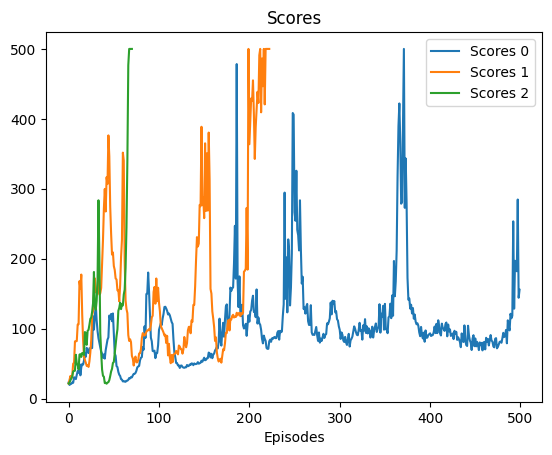

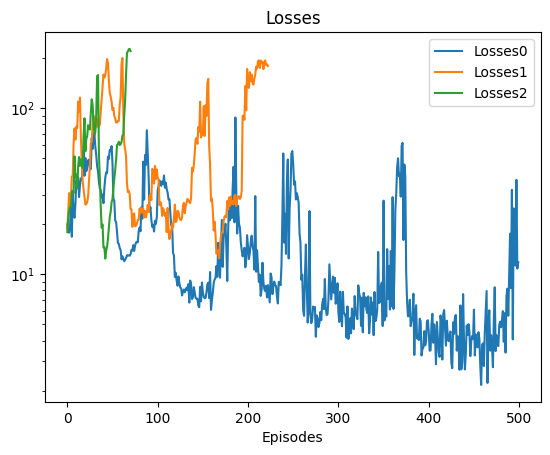

In [17]:
# Plot the scores and losses vs the episodes
fig, ax1 = plt.subplots()

for i in range(trials):
    ax1.plot(episodes[i], scores[i], label='Scores ' + str(i))

ax1.set_xlabel('Episodes')
plt.legend(loc='best')
plt.title('Scores')
plt.show()

# Plot the losses
fig, ax1 = plt.subplots()

for i in range(trials):
    ax1.semilogy(episodes[i], losses[i], label='Losses' + str(i))

ax1.set_xlabel('Episodes')
plt.legend(loc='best')
plt.title('Losses')
plt.show()

Finally, we will visualize the learned policy.

Obtaining data from trained network
Data obtained
Creating animation


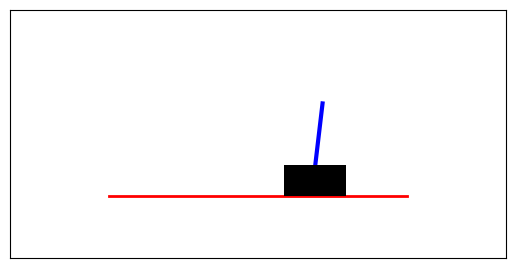

In [18]:
# Run the game once with the trained network and store the values of the position and angle of the cartpole
print("Obtaining data from trained network")
pos_vector=[]
angle_vector=[]
state, _ = env.reset()
state = np.reshape(state, [1, agent.state_size])
done=False
while not done:
    pos_vector.append(state[0,0])
    angle_vector.append(state[0,2])
    action = agent.get_action(state)
    next_state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    next_state = np.reshape(next_state, [1, agent.state_size])
    state = next_state
    if done:
        break
T=len(pos_vector)
print("Data obtained")

# Animate the data: to observe what our network has learned
from matplotlib import animation, patches
from IPython.display import HTML
print("Creating animation")
fig = plt.figure()
ax = plt.axes(xlim=(-4, 4), ylim=(-1, 3), aspect=1)
ax.set_xticks([])
ax.set_yticks([])

mag1 = plt.Rectangle((0,0), width= 1, height= 0.5, angle=0, fc='black', alpha=0)
line1, = ax.plot([], [], 'b', zorder=1,linewidth=3.0)
line2, = ax.plot([], [], 'r', zorder=1,linewidth=2.0)

def init():
    line1.set_data([], [])
    line2.set_data([], [])
    ax.add_patch(mag1)
    return mag1, line1, line2,

def animate(i):
    mag1.set_alpha(1)
    mag1.xy = (pos_vector[i],0)
    x0=pos_vector[i]+0.5
    y0=0.5
    x1=x0+np.cos(np.pi/2-angle_vector[i])
    y1=y0+np.sin(np.pi/2-angle_vector[i])
    line1.set_data([x0, x1], [y0, y1])
    line2.set_data([-2.4, 2.4], [0,0])
    return mag1, line1, line2,

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=T,
                               interval=25, blit=True)

HTML(anim.to_jshtml())